In [ ]:
import os

# 1. 저장할 경로 설정
target_dir = "/home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/"
filename = "rasch_fixed_difficulty.stan"
full_path = os.path.join(target_dir, filename)

# 2. Stan 모델 코드
stan_code = """
data {
  int<lower=1> N;   // 학생 수
  int<lower=1> J;   // 문항 수
  array[N, J] int<lower=0, upper=1> y;  // 응답 행렬 (N x J)
  vector[J] difficulty; // 이미 알고 있는 문항 난이도
}

parameters {
  vector[N] ability;    // 추정해야 할 학생의 능력
}

model {
  // Prior for ability (사용자 지정: 표준편차 5)
  ability ~ normal(0, 5);

  // Likelihood
  for (j in 1:J) {
    for (n in 1:N) {
      // [수정] difficulty는 벡터이므로 j번째 문항의 난이도를 특정해야 함
      y[n,j] ~ bernoulli_logit(ability[n] - difficulty[j]);
    }
  }
}
"""

# 3. 디렉토리 존재 여부 확인 및 파일 저장
try:
    # 만약 해당 경로가 없다면 생성 (선택 사항)
    os.makedirs(target_dir, exist_ok=True) 
    
    with open(full_path, 'w') as f:
        f.write(stan_code)
    print(f">>> 성공적으로 저장되었습니다:\n{full_path}")

except OSError as e:
    print(f">>> 경로 저장 중 에러 발생: {e}")

>>> 성공적으로 저장되었습니다:
/home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty.stan


In [25]:
from cmdstanpy import CmdStanModel

# 저장된 파일 경로 지정
stan_file_path = "/home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty.stan"

print(f">>> 모델 컴파일 시작: {stan_file_path}")

try:
    # 모델 컴파일
    model = CmdStanModel(stan_file=stan_file_path)
    print(">>> 모델이 성공적으로 로드되고 컴파일되었습니다.")
    print(f">>> 모델 이름: {model.name}")
    print(f">>> 실행 파일 경로: {model.exe_file}")
    
except Exception as e:
    print(f">>> 컴파일 에러 발생: {e}")

14:40:24 - cmdstanpy - INFO - compiling stan file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty.stan to exe file /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty


>>> 모델 컴파일 시작: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty.stan


14:40:44 - cmdstanpy - INFO - compiled model executable: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty


>>> 모델이 성공적으로 로드되고 컴파일되었습니다.
>>> 모델 이름: rasch_fixed_difficulty
>>> 실행 파일 경로: /home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty


In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel

# 그래프 스타일 설정
az.style.use("arviz-darkgrid")
print("라이브러리 로드 완료")

라이브러리 로드 완료


In [27]:
# 재현성을 위한 시드 설정
np.random.seed(1234)

# 1. 설정
N = 10  # 학생 수
J = 200  # 문항 수

# 2. 파라미터 생성
# (1) 문항 난이도 (Known Difficulty): 이미 알고 있다고 가정 (Data)
known_difficulty = np.random.normal(0, 1, J)

# (2) 학생 능력 (True Ability): 우리가 맞춰야 할 정답 (Parameter)
true_ability = np.random.normal(0, 1, N)

# 3. 응답 데이터(y) 생성 (Rasch Model 확률 기반)
y_matrix = np.zeros((N, J), dtype=int)

for n in range(N):
    for j in range(J):
        # 로짓 계산: 능력 - 난이도
        logit = true_ability[n] - known_difficulty[j]
        # 확률 계산 (Sigmoid)
        prob = 1 / (1 + np.exp(-logit))
        # 베르누이 시행으로 0 또는 1 생성
        y_matrix[n, j] = np.random.binomial(1, prob)

print(f"데이터 생성 완료: 학생 {N}명, 문항 {J}개")
print(f"응답 행렬 크기: {y_matrix.shape}")

데이터 생성 완료: 학생 10명, 문항 200개
응답 행렬 크기: (10, 200)


In [28]:
# 1. Stan 파일 경로 지정
base_path = "/home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/"
stan_file = os.path.join(base_path, "rasch_fixed_difficulty.stan")

# 2. 모델 컴파일
print(f"모델 컴파일 중... ({stan_file})")
model = CmdStanModel(stan_file=stan_file)

# 3. 데이터 딕셔너리 구성
stan_data = {
    'N': N,
    'J': J,
    'y': y_matrix.tolist(),      # 행렬 형태 그대로 전달
    'difficulty': known_difficulty.tolist() # 난이도 벡터 전달
}

# 4. MCMC 샘플링 수행
print("샘플링 시작...")
fit = model.sample(
    data=stan_data,
    iter_sampling=2000,
    iter_warmup=1000,
    chains=4,
    seed=42
)

print("샘플링 완료!")

14:40:45 - cmdstanpy - INFO - CmdStan start processing


모델 컴파일 중... (/home/atruergod/git/Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python/rasch_fixed_difficulty.stan)
샘플링 시작...


chain 1 |          | 00:00 Status





chain 1 |▋         | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)


chain 1 |▉         | 00:00 Iteration:  100 / 3000 [  3%]  (Warmup)


chain 1 |█▎        | 00:01 Iteration:  200 / 3000 [  6%]  (Warmup)


chain 1 |█▌        | 00:01 Iteration:  300 / 3000 [ 10%]  (Warmup)


chain 1 |█▉        | 00:01 Iteration:  400 / 3000 [ 13%]  (Warmup)


chain 1 |██▏       | 00:02 Iteration:  500 / 3000 [ 16%]  (Warmup)


chain 1 |██▌       | 00:02 Iteration:  600 / 3000 [ 20%]  (Warmup)


chain 1 |██▊       | 00:03 Iteration:  700 / 3000 [ 23%]  (Warmup)


chain 1 |███▏      | 00:03 Iteration:  800 / 3000 [ 26%]  (Warmup)


chain 1 |███▍      | 00:03 Iteration:  900 / 3000 [ 30%]  (Warmup)


chain 1 |████      | 00:04 Iteration: 1001 / 3000 [ 33%]  (Sampling)


chain 1 |████▍     | 00:04 Iteration: 1100 / 3000 [ 36%]  (Sampling)


chain 1 |████▋     | 00:04 Iteration: 1200 / 3000 [ 40%]  (Sampling)




chain 1 |█████     | 00:05 Iteration: 1300 / 3000 [ 43%]


14:40:56 - cmdstanpy - INFO - CmdStan done processing.



샘플링 완료!


/tmp/ipykernel_14791/748715802.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


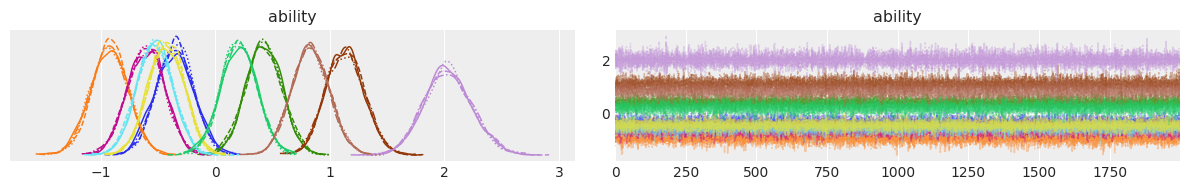

             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
ability[0] -0.357  0.163  -0.664   -0.052      0.001    0.002   17586.0   
ability[1] -0.926  0.164  -1.244   -0.630      0.001    0.002   16019.0   
ability[2]  0.421  0.157   0.134    0.733      0.001    0.002   16317.0   
ability[3] -0.606  0.162  -0.896   -0.296      0.001    0.002   15323.0   
ability[4]  1.132  0.168   0.828    1.453      0.001    0.002   16243.0   

            ess_tail  r_hat  
ability[0]    6298.0    1.0  
ability[1]    6022.0    1.0  
ability[2]    5700.0    1.0  
ability[3]    6061.0    1.0  
ability[4]    6354.0    1.0  


In [34]:
# ArviZ 데이터 객체로 변환
idata = az.from_cmdstanpy(
    posterior=fit,
    observed_data={"y": y_matrix},
    constant_data={"difficulty": known_difficulty}
)

# Traceplot 그리기 (학생 3명만 예시로 확인)
# var_names를 지정하지 않으면 모든 학생이 나옵니다.
az.plot_trace(idata, var_names=["ability"])
plt.tight_layout()
plt.show()

# 요약 통계량 (R_hat 확인)
summary = az.summary(idata, var_names=["ability"])
print(summary.head()) # 상위 5명 출력

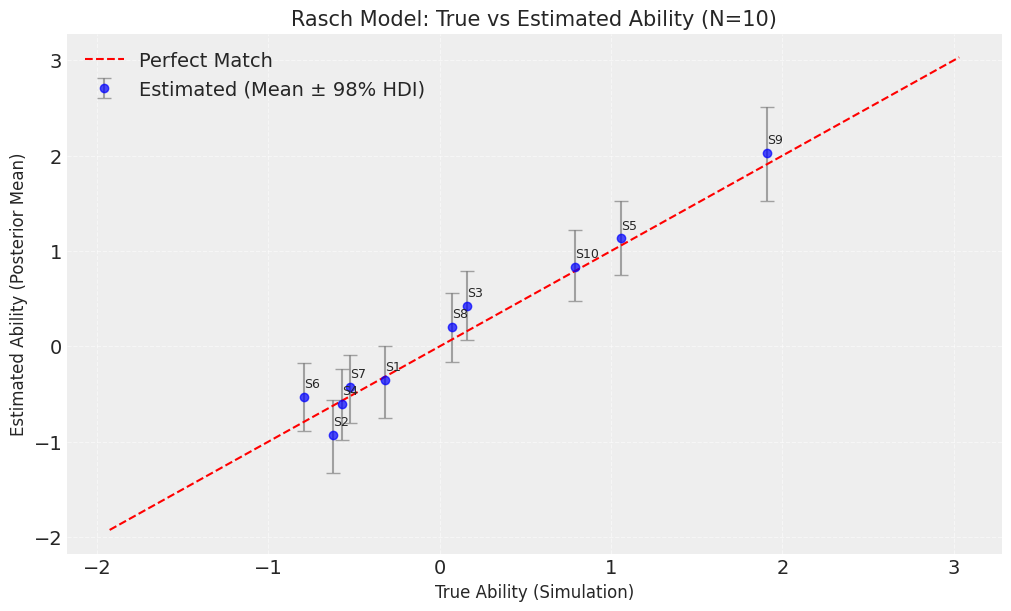

In [30]:
# 1. 추정치 추출 (Posterior Mean & 94% HDI)
# ArviZ의 summary 기능을 활용
summary_df = az.summary(idata, var_names=["ability"], hdi_prob=0.98)

# 인덱스 정렬 및 데이터 병합
summary_df['true_ability'] = true_ability
summary_df = summary_df.reset_index()

# 2. 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))

# (1) 오차 막대 그래프 (추정치)
ax.errorbar(
    x=summary_df['true_ability'],
    y=summary_df['mean'],
    yerr=[summary_df['mean'] - summary_df['hdi_1%'], summary_df['hdi_99%'] - summary_df['mean']],
    fmt='o', 
    color='blue', 
    ecolor='gray', 
    alpha=0.7, 
    capsize=5, 
    label='Estimated (Mean ± 98% HDI)'
)

# (2) 기준선 (y=x)
min_val = min(summary_df['true_ability'].min(), summary_df['mean'].min()) - 1
max_val = max(summary_df['true_ability'].max(), summary_df['mean'].max()) + 1
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Match')

# (3) 라벨링
for i, row in summary_df.iterrows():
    ax.text(row['true_ability'], row['mean'] + 0.1, f"S{i+1}", fontsize=9)

ax.set_title(f"Rasch Model: True vs Estimated Ability (N={N})", fontsize=15)
ax.set_xlabel("True Ability (Simulation)", fontsize=12)
ax.set_ylabel("Estimated Ability (Posterior Mean)", fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

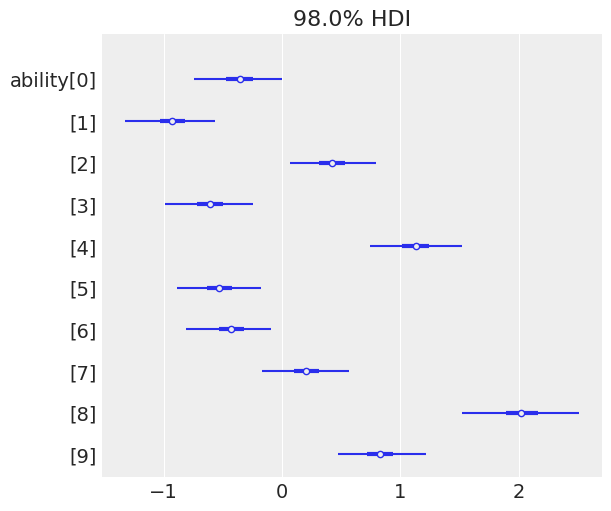

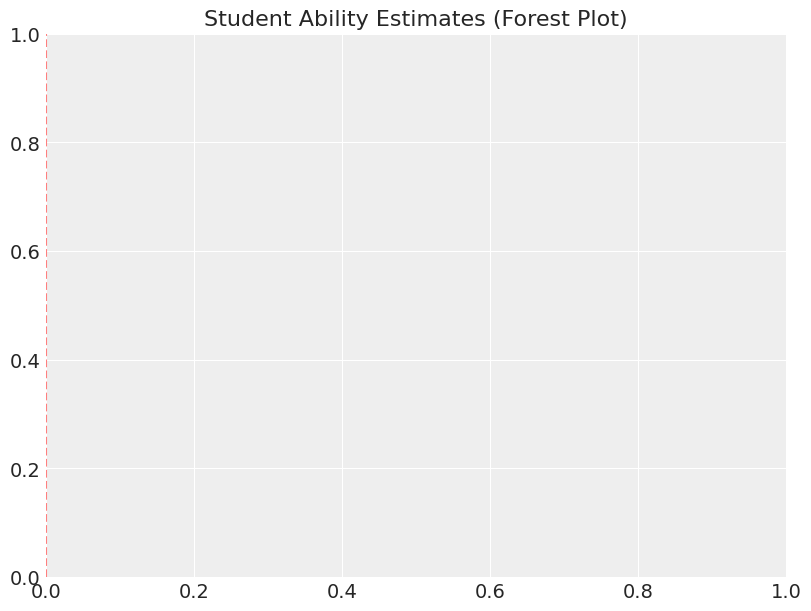

In [31]:

az.plot_forest(idata, var_names=["ability"], combined=True, hdi_prob=0.98)
plt.figure(figsize=(8, 6))
plt.title("Student Ability Estimates (Forest Plot)")
plt.axvline(0, color='red', linestyle='--', alpha=0.5) # 평균(0) 기준선
plt.show()

/tmp/ipykernel_14791/1263232996.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


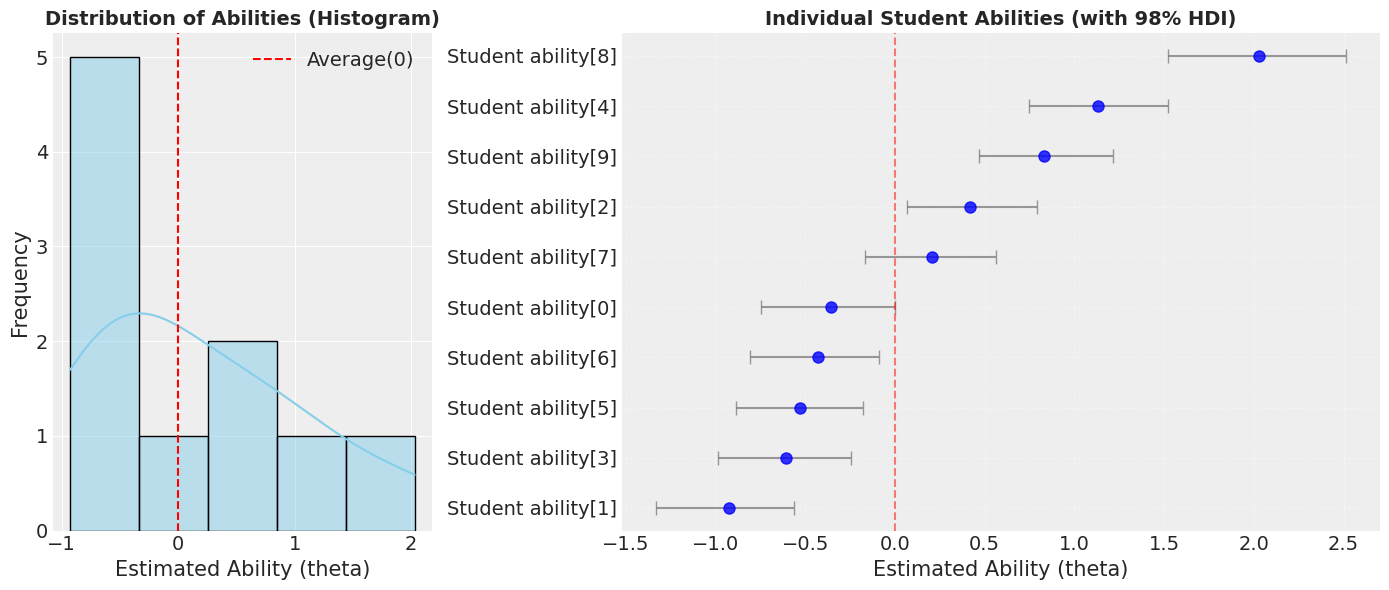

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns # 스타일과 히스토그램을 위해 사용 (없으면 pip install seaborn)

# 1. 데이터 준비 (능력치 순으로 정렬하면 보기가 더 좋습니다)
# summary_df는 이전 코드 결과물이라고 가정합니다.
sorted_df = summary_df.sort_values('mean', ascending=True)

# 2. 캔버스 설정 (1행 2열)
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# --- [왼쪽] 히스토그램: 집단 전체의 능력 분포 ---
sns.histplot(sorted_df['mean'], kde=True, ax=ax[0], color='skyblue', bins=5)
ax[0].set_title('Distribution of Abilities (Histogram)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Estimated Ability (theta)')
ax[0].set_ylabel('Frequency')
ax[0].axvline(0, color='red', linestyle='--', label='Average(0)') # 기준선
ax[0].legend()

# --- [오른쪽] Forest Plot: 개별 학생의 추정치 및 신용구간 ---
# 오차 막대 계산 (상한값 - 평균, 평균 - 하한값)
y_err = [
    sorted_df['mean'] - sorted_df['hdi_1%'], 
    sorted_df['hdi_99%'] - sorted_df['mean']
]

# 가로형 Error Bar Plot
ax[1].errorbar(
    x=sorted_df['mean'], 
    y=range(len(sorted_df)), # y축 위치
    xerr=y_err, 
    fmt='o',          # 점 모양
    markersize=8, 
    capsize=5,        # 에러바 캡 크기
    color='blue', 
    ecolor='gray',    # 에러바 색상
    alpha=0.8,
    label='Mean & 98% HDI'
)

# 시각적 보조 요소 추가
ax[1].set_yticks(range(len(sorted_df)))
ax[1].set_yticklabels([f"Student {i}" for i in sorted_df['index']]) # 원래 학생 번호 표시
ax[1].axvline(0, color='red', linestyle='--', alpha=0.5) # 능력 평균 0 기준선
ax[1].set_title('Individual Student Abilities (with 98% HDI)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Estimated Ability (theta)')
ax[1].grid(True, linestyle=':', alpha=0.6)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

/tmp/ipykernel_14791/2941508712.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


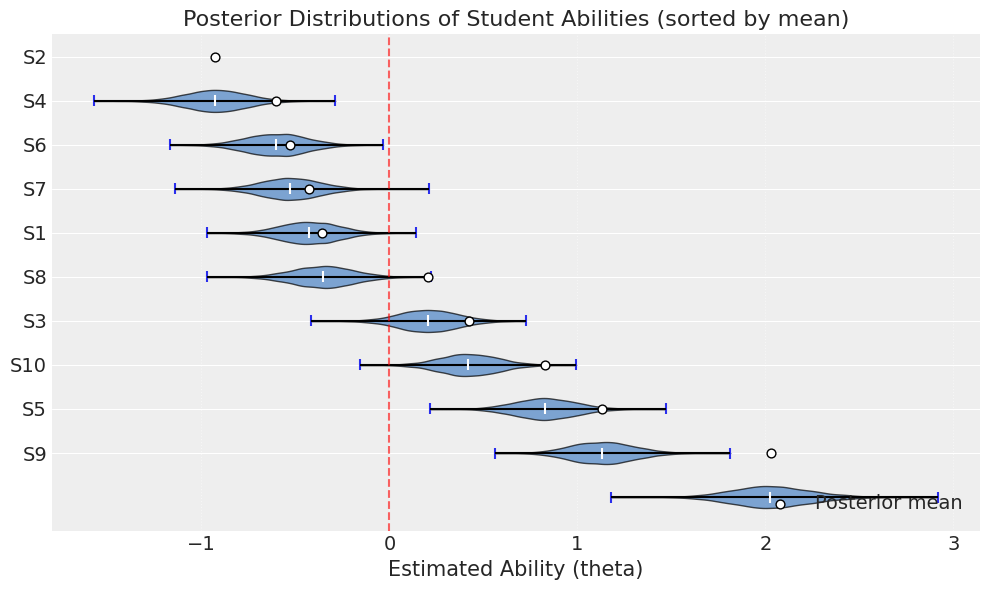

In [33]:
# Violin plots of individual student abilities sorted by posterior mean
# Uses existing variables: idata, sorted_df, N, plt, np, sns

# 1) Extract posterior samples: shape (chains, draws, N) -> reshape to (samples, N)
ability_vals = idata.posterior["ability"].values
samples = ability_vals.reshape(-1, N)  # (n_samples, N)

# 2) Determine student order from sorted_df (strings like "ability[7]")
order_indices = sorted_df['index'].str.extract(r'\[(\d+)\]')[0].astype(int).tolist()

# 3) Prepare data arrays in sorted order and labels (1-based student IDs)
samples_list = [samples[:, idx] for idx in order_indices]
labels = [f"S{idx+1}" for idx in order_indices]

# 4) Plot horizontal violins with posterior means overlaid
fig, ax = plt.subplots(figsize=(10, 6))
parts = ax.violinplot(samples_list, vert=False, showmeans=False, showmedians=True)

# style violins
for pc in parts['bodies']:
    pc.set_facecolor('#4C84C6')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
if 'cmedians' in parts:
    parts['cmedians'].set_color('white')
if 'cbars' in parts:
    parts['cbars'].set_color('black')

# overlay posterior means
means = [arr.mean() for arr in samples_list]
ax.scatter(means, range(len(labels)), marker='o', s=40, color='white', edgecolor='black', zorder=3, label='Posterior mean')

# formatting
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.invert_yaxis()                # keep lowest mean at top (sorted ascending)
ax.axvline(0, color='red', linestyle='--', alpha=0.6)  # reference line
ax.set_xlabel('Estimated Ability (theta)')
ax.set_title('Posterior Distributions of Student Abilities (sorted by mean)')
ax.grid(axis='x', linestyle=':', alpha=0.5)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()